# Student_exam_oriented_ex_8_1

In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/jdariasl/OTBD/main/content/init.py
import init; init.init(force_download=False)

In [2]:
#!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

In [12]:
import numpy as np
from local.lib.data import load_data
import scipy as sc
import matplotlib.pyplot as plt
import tensorflow as tf

2023-10-19 16:07:59.616072: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
#!pip install cvxpy

In [3]:
import cvxpy as cp

## Exercise


- Algorithm: Centralised ADMM using TF
- Problem: Binary classification using SVM

$$\underset{{\bf{w}}}{\arg\min}f({\bf{w}})=\underset{{\bf{w}}\in\mathbb{R}^{d+1}}{\textrm{ arg min}}\left(\frac{1}{n}\sum_{i=1}^n\textrm{max}\left(1-y_{i}\left({\bf{w}}^{T}{\bf{x}}_{i}\right),0\right)+\frac{\lambda}{2}\left\Vert {\bf{w}}\right\Vert _{2}^{2}\right)$$

- Breast cancer dataset
    - 10 features: ID of patient and biological properties of the tumor.
        - We use 8 features: $\bf{X}$ is a $500\times 8$ matrix containing 500 dataset entries.
    - Target: to classify the tumor as malign or benign.
        -  Thus, ${\bf{y}}$ is a $500\times1$ vector containing the labels
        
**Hints:**

You must optimise the extended lagrangian function:

$$
L_{\rho}\left({\bf{w}},{\bf{z}},{\bf{\beta}}\right)=g\left({\bf{w}}\right)+h\left({\bf{z}}\right)+{\bf{\beta}}^{T}\left({\bf{w}}-{\bf{z}}\right)+\frac{\rho}{2}\left\Vert {\bf{w}}-{\bf{z}}\right\Vert _{2}^{2}
$$

Since the regularization term is the $L_2$ norm, you can either (**1**) use the analytical solution for ${\bf{z}}$ or (**2**) optimse the lagrangian for ${\bf{z}}$ using autograd.

In [4]:
#load data
X,y = load_data("classification", 7)
n,d = X.shape

In [5]:
# Constant parameters
lamb = 0.01   # regularisation parameter
Niter= 3000   # Number of iterations for each algorithm
eta = 0.001   # step size 

In [8]:
#cvx_solver
def solver_cvx(n,X,Y,lamb,objective_fn):
    n_columns = X.shape[1]
    w = cp.Variable(n_columns)
    lambd = cp.Parameter(nonneg=True)
    lambd.value = lamb
    problem = cp.Problem(
        cp.Minimize(objective_fn(n, X, Y, w, lambd))
    )
    problem.solve(solver=cp.ECOS)
    return w.value

In [67]:
# Definition of the problem
#===================================
loss_fn = lambda n, X, Y, w: (1/n)*cp.sum(cp.pos(1-cp.multiply(Y,X @ w)))
reg_L2 = lambda w: cp.pnorm(w, p=2)**2
loss_svm_L2 = lambda n, X, Y, w, lambd: loss_fn(n, X, Y, w) + (lambd/2) * reg_L2(w)

# Solution of the empirical risk using CVX
w_svm_cvx=solver_cvx(n,X,y,lamb,loss_svm_L2)

w = cp.Variable(w_svm_cvx.shape[0])
w.value = w_svm_cvx
f_cvx=loss_svm_L2(n,X,y,w_svm_cvx,lamb).value

print(f'The loss function f at the optimum takes the value {f_cvx}')

f_cvx = (np.kron(f_cvx,np.ones((1,Niter+1)))).flatten()

The loss function f at the optimum takes the value 0.42642274201112185


In [10]:
#Function that estimates the loss for several w at once.
f = lambda n, X, Y, w, lambd: (1/n)*np.sum(np.maximum(np.zeros((n,w.shape[1])),np.ones((n,w.shape[1]))-np.diag(Y)@(X@w)),axis=0) + (lambd/2)*np.sum(w**2,axis=0)

In [78]:
# ADMM centralized with TF

#Constants
ro=1               # Quadratic term
subgrad_steps = 10 #Number of gradient steps per ADMM update

X =  X.astype(np.float32)
y =  y.astype(np.float32)


@tf.function
def loss_lag(func_g,X,Y,w,z,b,lamb,rho):
    # Define the langrangian function using TF primitives
    return ...

w = tf.Variable(initial_value=np.zeros(d).reshape(-1,1), dtype=tf.float32)
z = tf.Variable(initial_value=np.zeros(d).reshape(-1,1), dtype=tf.float32)
b = tf.Variable(initial_value=np.zeros(d).reshape(-1,1), dtype=tf.float32)
w_admm_tf = [np.zeros(d)]

#optimisation loop
for _ in range(Niter):
    for _ in range(subgrad_steps):
        #Implement the updating formulas for w, z and beta. 
        with tf.GradientTape() as t:
             
            w...
    
    #Depending on the option for z, it can be optimised using analytical expressions or runing 
    # gradient descent for a number of subgrad_steps iterations.
    z...
    
    b...
    
    w_admm_tf.append(w.numpy().flatten())
w_admm_tf = np.r_[w_admm_tf]
f_admm_tf=f(n,X,y,w_admm_tf.T,lamb)

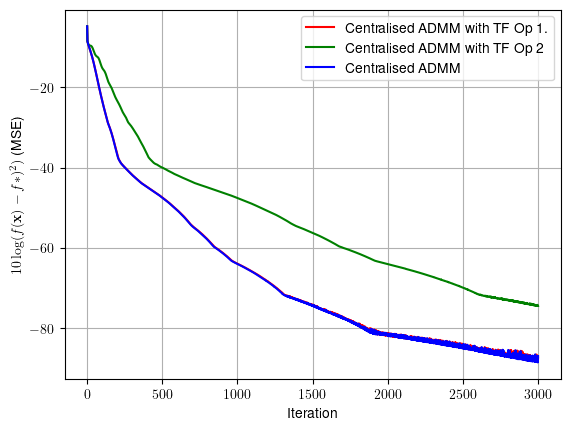

In [79]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
t = range(Niter+1)
plt.plot(t, 10*np.log10((f_admm_tf-f_cvx)**2+np.finfo(float).eps), color = 'r',label = 'Centralised ADMM with TF')
plt.grid()
plt.legend()
plt.xlabel('Iteration')
plt.ylabel(r'$10\log(f({\bf{x}})-f*)^2)$ (MSE)')
plt.show()